Number of RSGs in LMC: 4655
Number of RSGs within 120" of LMC SUMS: 1713
Number of RSGs within 120" of LMC SUMS: 1713


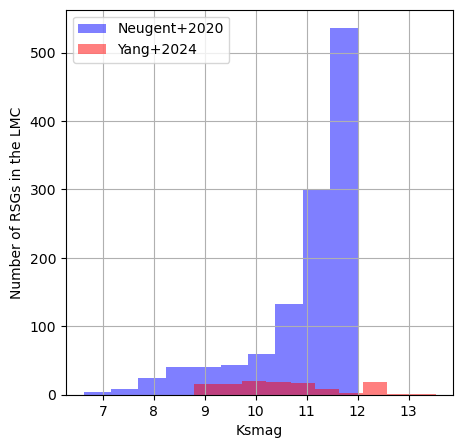

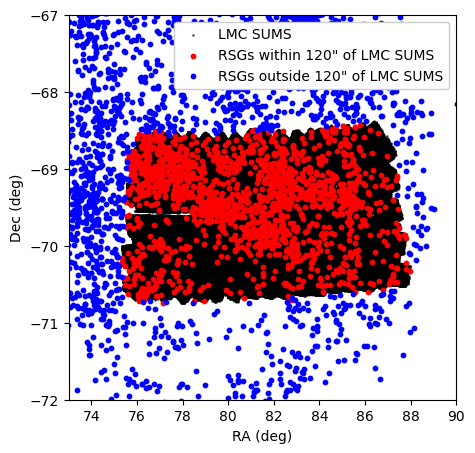

In [105]:
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.coordinates import SkyCoord
import astropy.units as u
# Astroquery Vizier 
from astroquery.vizier import Vizier
vizier = Vizier()
vizier.ROW_LIMIT = -1
data_dir = os.getenv("DATADIR")


# From Neugent+2020 - LMC 
# https://ui.adsabs.harvard.edu/abs/2020ApJ...900..118N/abstract
neugent20 = vizier.get_catalogs("J/ApJ/900/118/table2")[0].to_pandas()
neugent_co = SkyCoord(ra=neugent20.RAJ2000, dec=neugent20.DEJ2000, unit=(u.hourangle, u.deg))
neugent20['RA'] = neugent_co.ra.deg
neugent20['Dec'] = neugent_co.dec.deg


# From Yang+2024 - LMC 
# https://iopscience.iop.org/article/10.3847/1538-4357/ad28c4/pdf
file = "https://content.cld.iop.org/journals/0004-637X/965/2/106/revision1/apjad28c4t2_mrt.txt"
yang24_vizier = Table.read(file, format='ascii').to_pandas()
yang24 = yang24_vizier[(yang24_vizier.chi2 == 'RSG') | (yang24_vizier.ML == 'RSG')].reset_index(drop=True) # Either the ML or chi2 classification is RSG
yang24_cos = SkyCoord(ra=yang24['RAdeg'], dec=yang24['DEdeg'], unit='deg')
yang24['RA'] = yang24_cos.ra.deg
yang24['Dec'] = yang24_cos.dec.deg

# SUMS Catalogs
sums = pd.read_csv(data_dir + '0_SUMS_Catalogs/FinalCatalogs/SUMS_UV_Catalog.csv')
lmc = sums[sums.RA > 30].reset_index(drop=True)
lmc_cos = SkyCoord(ra=lmc['RA'], dec=lmc['Dec'], unit='deg')

# Crossmatch to track dupes, if a yang24 source is within 1" of a neugent20 source, drop it 
yang24_dupe_index = []
neugent20_dupe_index = []
for i, star in enumerate(yang24_cos):
    distances = star.separation(neugent_co).arcsecond
    if distances.min() < 1:
        yang24_dupe_index.append(i)
        neugent20_dupe_index.append(distances.argmin())

# Drop from yang24 if already in neugent20
yang24 = yang24.drop(yang24_dupe_index).reset_index(drop=True)
neugent20['cat'] = 'neugent20'
neugent20.loc[neugent20_dupe_index, 'cat'] = 'neugent20_yang24'
yang24['cat'] = 'yang24'

# Save in a new dataframe the ra, dec, Ksmag, and cat columns
lmc_rsgs = pd.concat([neugent20[['RA', 'Dec', 'Ksmag', 'cat']], yang24[['RA', 'Dec', 'Ksmag', 'cat']]], ignore_index=True)
lmc_rsg_cos = SkyCoord(ra=lmc_rsgs['RA'], dec=lmc_rsgs['Dec'], unit='deg')
print(f"Number of RSGs in LMC: {len(lmc_rsgs)}")


# What is in our footprint
keep_index = []
drop_index = []
threshold = 120
for i, star in enumerate(lmc_rsg_cos):
    distances = star.separation(lmc_cos).arcsecond
    if distances.min() < threshold:
        keep_index.append(i)
    else:
        drop_index.append(i)

rsgs_in_sums_lmc = lmc_rsgs.iloc[keep_index].reset_index(drop=True)
print(f"Number of RSGs within {threshold}\" of LMC SUMS: {len(rsgs_in_sums_lmc)}")
rsgs_in_sums_lmc.to_csv(data_dir + '0_SUMS_Catalogs/RSGs/SUMS_Neugent20_Yang24_RSGs_2arcmin.csv', index=False)

plt.figure(figsize=(5, 5))
rsgs_in_sums_lmc[rsgs_in_sums_lmc.cat == 'neugent20'].Ksmag.hist(color='blue', alpha=0.5, label='Neugent+2020')
rsgs_in_sums_lmc[rsgs_in_sums_lmc.cat == 'yang24'].Ksmag.hist(color='red', alpha=0.5, label='Yang+2024')
plt.xlabel('Ksmag')
plt.ylabel('Number of RSGs in the LMC')
plt.legend()

plt.figure(figsize=(5, 5))
plt.scatter(lmc_cos.ra, lmc_cos.dec, s=1, color='black', alpha=0.5, label='LMC SUMS')
plt.scatter(lmc_rsg_cos.ra[keep_index], lmc_rsg_cos.dec[keep_index], s=10, color='red', label=f'RSGs within {threshold}" of LMC SUMS')
plt.scatter(lmc_rsg_cos.ra[drop_index], lmc_rsg_cos.dec[drop_index], s=10, color='blue', label=f'RSGs outside {threshold}" of LMC SUMS')
plt.xlim(73.,90)
plt.ylim(-72,-67.)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend(facecolor='white', framealpha=1, loc='upper right')
print(f"Number of RSGs within {threshold}\" of LMC SUMS: {len(keep_index)}")

Number of RSGs in SMC: 2121
Number of RSGs within 120" of SMC SUMS: 1499


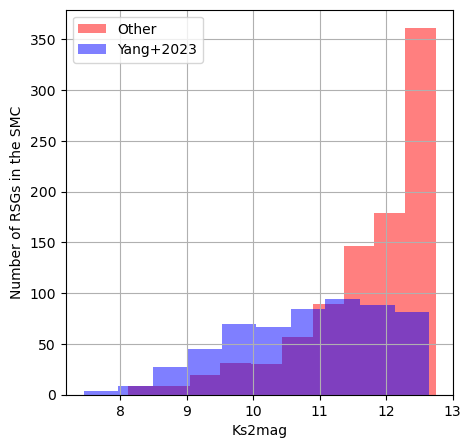

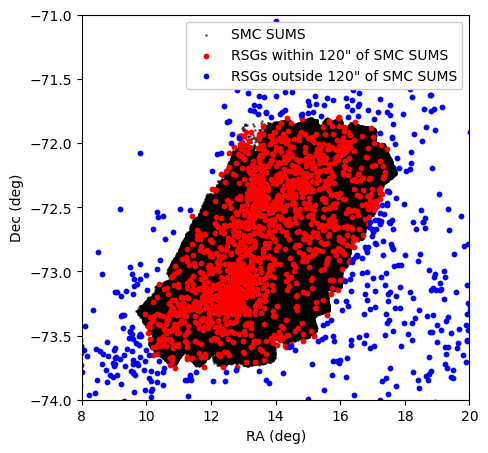

In [128]:
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.coordinates import SkyCoord
import astropy.units as u
# Astroquery Vizier 
from astroquery.vizier import Vizier
vizier = Vizier(columns=['*','**'])
vizier.ROW_LIMIT = -1
data_dir = os.getenv("DATADIR")


# From Yang+2020 - SMC
# https://www.aanda.org/articles/aa/full_html/2020/07/aa37168-19/aa37168-19.html
# Note (1)  : Rank as follows:
# -1 =	spectroscopic RSGs
# 0-4 =	photometric RSG candidates we ranked (Rank 0 to 5) the candidates based on the intersection between different CMDs
# Rank 0 indicated that a target was identified as the same type of evolved massive star in all five datasets (Gaia, SkyMapper, NSC, M2002 and 2MASS) by the MIST models and so on
# Rank 5 indicated the additional RSG candidates identified by the CB method but not recovered by the MIST models.
yang20 = vizier.get_catalogs("J/A+A/639/A116/table2")[0].to_pandas()
yang20_cos = SkyCoord(ra=yang20['RAJ2000'], dec=yang20['DEJ2000'], unit='deg')
yang20['RA'] = yang20_cos.ra.deg
yang20['Dec'] = yang20_cos.dec.deg

# From Yang+2023 - SMC
# https://ui.adsabs.harvard.edu/abs/2023A%26A...676A..84Y/abstract
# Note (1)  : Rank as follows:
# -1 =	spectroscopic RSGs
# 0-4 =	photometric RSG candidates we ranked (Rank 0 to 5) the candidates based on the intersection between different CMDs
# Rank 0 indicated that a target was identified as the same type of evolved massive star in all five datasets (Gaia, SkyMapper, NSC, M2002 and 2MASS) by the MIST models and so on
# Rank 5 indicated the additional RSG candidates identified by the CB method but not recovered by the MIST models.
yang23 = vizier.get_catalogs("J/A+A/676/A84/table2")[0].to_pandas()
yang23_cos = SkyCoord(ra=yang23['RAJ2000'], dec=yang23['DEJ2000'], unit='deg')
yang23['RA'] = yang23_cos.ra.deg
yang23['Dec'] = yang23_cos.dec.deg

# SUMS Catalogs
sums = pd.read_csv(data_dir + '0_SUMS_Catalogs/FinalCatalogs/SUMS_UV_Catalog.csv')
smc = sums[sums.RA < 30].reset_index(drop=True)
smc_cos = SkyCoord(ra=smc['RA'], dec=smc['Dec'], unit='deg')

print(f"Number of RSGs in SMC: {len(yang23)}")


# What is in our footprint
keep_index = []
drop_index = []
threshold = 120
for i, star in enumerate(yang23_cos):
    distances = star.separation(smc_cos).arcsecond
    if distances.min() < threshold:
        keep_index.append(i)
    else:
        drop_index.append(i)

rsgs_in_sums_smc = yang23.iloc[keep_index].reset_index(drop=True)
print(f"Number of RSGs within {threshold}\" of SMC SUMS: {len(rsgs_in_sums_smc)}")
rsgs_in_sums_smc.to_csv(data_dir + '0_SUMS_Catalogs/RSGs/SUMS_Yang23_RSGs_2arcmin.csv', index=False)

plt.figure(figsize=(5, 5))
rsgs_in_sums_smc[rsgs_in_sums_smc.ID.isna()].Ks2mag.hist(color='red', alpha=0.5, label='Other')
rsgs_in_sums_smc[~rsgs_in_sums_smc.ID.isna()].Ks2mag.hist(color='blue', alpha=0.5, label='Yang+2023')

plt.xlabel('Ks2mag')
plt.ylabel('Number of RSGs in the SMC')
plt.legend()

plt.figure(figsize=(5, 5))
plt.scatter(smc_cos.ra, smc_cos.dec, s=1, color='black', alpha=0.5, label='SMC SUMS')
plt.scatter(yang23_cos.ra[keep_index], yang23_cos.dec[keep_index], s=10, color='red', label=f'RSGs within {threshold}" of SMC SUMS')
plt.scatter(yang23_cos.ra[drop_index], yang23_cos.dec[drop_index], s=10, color='blue', label=f'RSGs outside {threshold}" of SMC SUMS')
plt.xlim(8,20)
plt.ylim(-74,-71.)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend(facecolor='white', framealpha=1, loc='upper right')


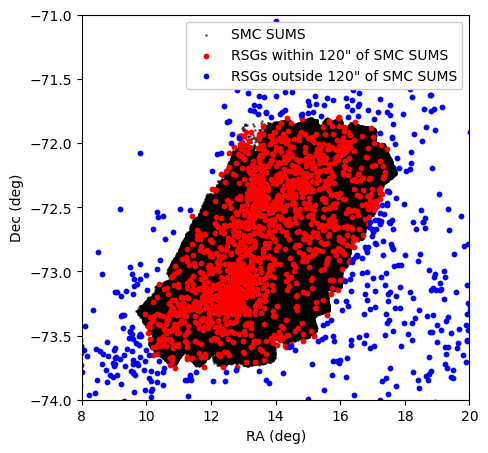

In [127]:
plt.figure(figsize=(5, 5))
plt.scatter(smc_cos.ra, smc_cos.dec, s=1, color='black', alpha=0.5, label='SMC SUMS')
plt.scatter(yang23_cos.ra[keep_index], yang23_cos.dec[keep_index], s=10, color='red', label=f'RSGs within {threshold}" of SMC SUMS')
plt.scatter(yang23_cos.ra[drop_index], yang23_cos.dec[drop_index], s=10, color='blue', label=f'RSGs outside {threshold}" of SMC SUMS')
plt.xlim(8,20)
plt.ylim(-74,-71.)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend(facecolor='white', framealpha=1, loc='upper right')